In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

pd.options.display.max_columns

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
# データの読込
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [5]:
train_df[['SaleCondition', 'SalePrice']].groupby(['SaleCondition'], as_index=False).mean().sort_values(by='SalePrice', ascending=False)

,SaleCondition,SalePrice
5,Partial,272291.752000
4,Normal,175202.219533
2,Alloca,167377.416667
3,Family,149600.000000
0,Abnorml,146526.623762
1,AdjLand,104125.000000


In [6]:
Condition_mapping = {'Normal': 0, 'Partial': 1, 'Abnorml': 2, 'Family': 3, 'Partial': 4, 'AdjLand': 5}
train_df['SaleConditionLabel'] = train_df['SaleCondition'].map(Condition_mapping)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
Id                    1460 non-null int64
MSSubClass            1460 non-null int64
MSZoning              1460 non-null object
LotFrontage           1201 non-null float64
LotArea               1460 non-null int64
Street                1460 non-null object
Alley                 91 non-null object
LotShape              1460 non-null object
LandContour           1460 non-null object
Utilities             1460 non-null object
LotConfig             1460 non-null object
LandSlope             1460 non-null object
Neighborhood          1460 non-null object
Condition1            1460 non-null object
Condition2            1460 non-null object
BldgType              1460 non-null object
HouseStyle            1460 non-null object
OverallQual           1460 non-null int64
OverallCond           1460 non-null int64
YearBuilt             1460 non-null int64
YearRemodAdd          1460 non-null int6

In [7]:
train_df[['SalePrice', 'MSZoning']].groupby(['MSZoning'], as_index=False).mean().sort_values(by='SalePrice', ascending=False)

,MSZoning,SalePrice
1,FV,214014.061538
3,RL,191004.994787
2,RH,131558.375000
4,RM,126316.830275
0,C (all),74528.000000


In [8]:
Condition_mapping = {'C (all)': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV':4}
train_df['MSZoningLabel'] = train_df['MSZoning'].map(Condition_mapping)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 83 columns):
Id                    1460 non-null int64
MSSubClass            1460 non-null int64
MSZoning              1460 non-null object
LotFrontage           1201 non-null float64
LotArea               1460 non-null int64
Street                1460 non-null object
Alley                 91 non-null object
LotShape              1460 non-null object
LandContour           1460 non-null object
Utilities             1460 non-null object
LotConfig             1460 non-null object
LandSlope             1460 non-null object
Neighborhood          1460 non-null object
Condition1            1460 non-null object
Condition2            1460 non-null object
BldgType              1460 non-null object
HouseStyle            1460 non-null object
OverallQual           1460 non-null int64
OverallCond           1460 non-null int64
YearBuilt             1460 non-null int64
YearRemodAdd          1460 non-null int6

In [9]:
train_df['TotalSF'] = train_df['TotalBsmtSF'] + train_df['1stFlrSF'] + train_df['2ndFlrSF']

In [10]:
# 目的変数と特徴量の設定
target_col = 'SalePrice'
feature_cols = ['OverallQual', 'GrLivArea', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'SaleConditionLabel', 'MSZoningLabel', 'TotalSF']
#feature_cols = ['OverallQual', 'GrLivArea', '2ndFlrSF', 'BsmtFinSF1', 'OverallCond', 'YearBuilt', 'SaleConditionLabel', 'MSSubClass', 'MSZoningLabel']

In [11]:
train_df[feature_cols]

,OverallQual,GrLivArea,1stFlrSF,2ndFlrSF,BsmtFinSF1,OverallCond,YearBuilt,SaleConditionLabel,MSZoningLabel,TotalSF
0,7,1710,856,854,706,5,2003,0.0,3,2566
1,6,1262,1262,0,978,8,1976,0.0,3,2524
2,7,1786,920,866,486,5,2001,0.0,3,2706
3,7,1717,961,756,216,5,1915,2.0,3,2473
4,8,2198,1145,1053,655,5,2000,0.0,3,3343
...,...,...,...,...,...,...,...,...,...,...
1455,6,1647,953,694,0,5,1999,0.0,3,2600
1456,6,2073,2073,0,790,6,1978,0.0,3,3615
1457,7,2340,1188,1152,275,9,1941,0.0,3,3492
1458,5,1078,1078,0,49,6,1950,0.0,3,2156


In [12]:
train_df[feature_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 10 columns):
OverallQual           1460 non-null int64
GrLivArea             1460 non-null int64
1stFlrSF              1460 non-null int64
2ndFlrSF              1460 non-null int64
BsmtFinSF1            1460 non-null int64
OverallCond           1460 non-null int64
YearBuilt             1460 non-null int64
SaleConditionLabel    1448 non-null float64
MSZoningLabel         1460 non-null int64
TotalSF               1460 non-null int64
dtypes: float64(1), int64(9)
memory usage: 114.2 KB


In [13]:
X = np.array(train_df[feature_cols])
Y = np.array(train_df[target_col])
X.shape, Y.shape

((1460, 10), (1460,))

In [14]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.3, random_state=0)

In [15]:
X_train.shape, Y_train.shape

((1022, 10), (1022,))

In [16]:
X_valid.shape, Y_valid.shape

((438, 10), (438,))

In [17]:
# 特徴量と目的変数をxgboostのデータ構造に変換する
xgb_train = xgb.DMatrix(X_train, label=Y_train)
xgb_valid = xgb.DMatrix(X_valid, label=Y_valid)

In [18]:
params = {'objective': 'reg:squarederror', 'silent': 1, 'random_state': 71}
num_round = 500

In [19]:
# 学習の実行
watchlist = [(xgb_train, 'train'), (xgb_valid, 'eval')]
model = xgb.train(params, xgb_train, num_round, evals=watchlist, early_stopping_rounds=10)

[0]	train-rmse:140823	eval-rmse:143818
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:101543	eval-rmse:103662
[2]	train-rmse:74113.4	eval-rmse:76520
[3]	train-rmse:55181.7	eval-rmse:58597.2
[4]	train-rmse:41873.2	eval-rmse:46582.7
[5]	train-rmse:32718	eval-rmse:38695.9
[6]	train-rmse:26367.9	eval-rmse:33896.8
[7]	train-rmse:22038.1	eval-rmse:31172.7
[8]	train-rmse:19122.6	eval-rmse:29564.1
[9]	train-rmse:17012.2	eval-rmse:28096.6
[10]	train-rmse:15737.4	eval-rmse:27411.2
[11]	train-rmse:14680	eval-rmse:26859.5
[12]	train-rmse:13871.8	eval-rmse:26519
[13]	train-rmse:13356.6	eval-rmse:26258
[14]	train-rmse:12948.8	eval-rmse:26099.1
[15]	train-rmse:12549.1	eval-rmse:26114.6
[16]	train-rmse:12376.7	eval-rmse:26071.3
[17]	train-rmse:11972.6	eval-rmse:25948.7
[18]	train-rmse:11769.3	eval-rmse:25905.8
[19]	train-rmse:11442.2	eval-rmse:25822
[20]	train-rmse:11243.3	eval-rmse:25820.6
[

In [20]:
xgb_pred = model.predict(xgb_valid)
print('MSE(勾配ブースティング木)：', mean_squared_error(Y_valid, xgb_pred))

MSE(勾配ブースティング木)： 668079751.1231264


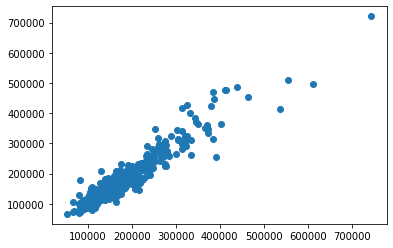

In [21]:
plt.scatter(Y_valid,xgb_pred )